###**Importing libraries**

In [1]:
import tensorflow as tf

In [2]:
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl


import numpy as np
import time
import functools

In [3]:
content_path="/content/content_nst.jpg"
style_path="/content/style_nst.jpg"

###**Function to load the image**

In [4]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)#reads the image from its path.
  img = tf.image.decode_image(img, channels=3)#detects the type of image and converts it to tensor
  img = tf.image.convert_image_dtype(img, tf.float32) #converts the pixels to float including normalization

  shape = tf.cast(tf.shape(img)[:-1], tf.float32) #takes height and width as float , .cast ----> for type conversion

  long_dim = max(shape) #take the max dimension present either height/width
 
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32) #to create the new shape
  
  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]# increases the dimension
  return img

###**Function to display the image**

In [5]:
# to display an image

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0) #removes dimension of size 1 from the shape of the tensor

  plt.imshow(image)
  if title:
    plt.title(title)

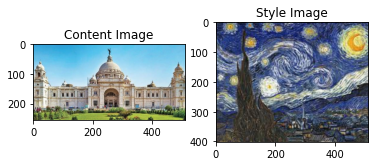

In [6]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [7]:
content_image.shape

TensorShape([1, 256, 512, 3])

###**Using VGG19 as the base model in transfer learning**

In [8]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet') # taking vgg 19 model without the later output layers 

print()
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 0s 0us/step

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [9]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

###**Function that creates a VGG model to return a list of inetrmediate outputs**

In [10]:
def vgg_layers(layer_names):
  
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

###**Example of the above function when the style image is passed**

In [11]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)  


#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs): #zip joins two tuples together
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 402, 512, 64)
  min:  0.0
  max:  828.316
  mean:  24.083746

block2_conv1
  shape:  (1, 201, 256, 128)
  min:  0.0
  max:  2977.105
  mean:  149.29877

block3_conv1
  shape:  (1, 100, 128, 256)
  min:  0.0
  max:  7419.6685
  mean:  143.8044

block4_conv1
  shape:  (1, 50, 64, 512)
  min:  0.0
  max:  13538.698
  mean:  541.2323

block5_conv1
  shape:  (1, 25, 32, 512)
  min:  0.0
  max:  3109.0295
  mean:  45.843094



###**Function to generate gram matrix for style extraction**

In [12]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) #forms the gram matrix. 
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations) 

###**Creating a model using Model subclassing API to extract and return the content and style of images**

In [13]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs) # Preprocess and ENCODES A BATCH OF IMAGES TO THE VGG19 MODEL
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}



#When called on an image,
# this model returns the gram matrix (style) of the style_layers and content of the content_layers

In [14]:
extractor = StyleContentModel(style_layers, content_layers)


In [15]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

###**Generate a random image and clip it**

In [16]:
image = tf.Variable(content_image)# IMAGE GENERATED

In [17]:
# SINCE THE MODEL ACCEPTS VALUES IN BETWEEN 0 AND 1 SO WE CLIP IT.

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


In [18]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1) 
#learning_rate( is the alpha), beta- exponential decay rate(closer to 1, better), epsilon- to prevent any division by 0

#To optimize this, use a weighted combination of the two losses to get the total loss
style_weight=1e-2
content_weight=1e4

###**Function to calculate the style and content loss**

In [19]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) #reduce_mean Computes the mean of elements across dimensions of a tensor.
                           for name in style_outputs.keys()]) #add_n Adds all input tensors element-wise.
    style_loss *= style_weight / num_style_layers #division is done so as to get style loss per layer

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

###**Function to calculate the validation loss**

In [20]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

In [21]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)

In [22]:
total_variation_weight=1e8

###**Function to calculate the derivative and apply the gradient descent**

In [23]:
@tf.function() #constructs a callable that executes a TensorFlow graph
def train_step(image):
  with tf.GradientTape() as tape: 
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*total_variation_loss(image)

  grad = tape.gradient(loss, image) #calculates gradient 
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))




###**Training the model**

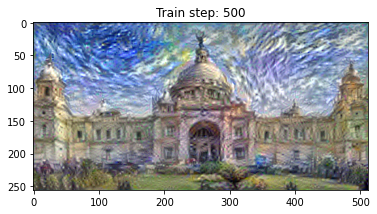

Total time: 28.1


In [24]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 50

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True) #dynamically update the plot
  imshow(image.read_value())
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))